# Loading
This section contains code for loading libraries used in the project and the dataset, as well as initializing the models and constants.

## Constants
These constants are loaded and used in the next sections
* `dataset`
* `tokenizer`

In [1]:
import torch
from transformers import AutoTokenizer, OPTForCausalLM
import pandas as pd
import numpy as np
from typing import Dict, List
import json
from pathlib import Path
import logging
from tqdm import tqdm
import argparse,os
import csv
from diffusers import UNet2DModel, AutoPipelineForText2Image, UNet2DModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import CLIPTextModel, CLIPTokenizer, CLIPTokenizerFast
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from PIL import Image
from diffusers import LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast

/home/eric/Projects/security_lab/SafeDiff/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eric/Projects/security_lab/SafeDiff/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/eric/Projects/security_lab/SafeDiff/.venv/lib/python3.12/site-packages/diffusers/models/vq_model.py:20: FutureWarning: `VQEncoderOutput` is deprecated and will be removed in version 0.31. Importing `VQEncoderOutput` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoders.vq_model import VQEncoderOutput`, instead.
  deprecate("VQEncoderOutput", "0.31", deprecation_message)
/home/eric/Projects/security_lab/SafeDiff/.venv/lib/python3.12/site-pack

In [2]:
def load_data(dataset_path="./dataset", dataset_name="i2p_benchmark"):
    dataset_file = os.path.join(dataset_path, f"{dataset_name}.csv")
    try:
        df = pd.read_csv(dataset_file)
    except FileNotFoundError as e:
        print(f"Dataset file {dataset_file} not found: {str(e)}")
        return None
    except pd.errors.ParserError as e:
        print(f"Error parsing the CSV file {dataset_file}: {str(e)}")
        return None
    except pd.errors.EmptyDataError as e:
        print(f"No data in CSV file {dataset_file}: {str(e)}")
        return None
    if 'embeddings' not in df.columns:
        df['embeddings'] = pd.Series(dtype='object')
    return df

In [3]:
# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
#tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device) 

In [4]:
text_encoder

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [5]:
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

In [6]:
# Load dataset
dataset = load_data("./dataset",'test')

# Detoxify
Experiment with detoxifying a prompt at a text-embedding level. Needs `dataset` loaded from the *Loading* stage.

First, `map_prompt_to_token` is used to convert the prompt to text embedding to be detoxified. Since our text embedding pads all text inputs by max length, whatever token that trails at the end of a prompt should be the padding used to detoxify. By examination, this padding is 49407.

The theory is that by substituting this padding when the instruction is toxic, the output image will be detoxified.

In [7]:
def map_prompt_to_token(prompt):
    """Converts prompt into a mapping of words inside prompt to their corresponding tokens"""
    # Tokenize and get embeddings
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt", return_offsets_mapping=True)

    # Load dataframe
    prompt_by_token = pd.DataFrame(columns=['token', 'text'])
    prompt_by_token['token'] = text_input.input_ids.numpy()[0]
    # Convert offset mapping to actual words
    for i, (text_start, text_end) in enumerate(text_input.offset_mapping.numpy()[0]):
        mapped_text = prompt[text_start:text_end]
        prompt_by_token.loc[i, 'text'] = mapped_text
    return prompt_by_token

In [8]:
# Test map_prompt_to_token. Notice that token 49407 follows the actual prompt.
token_text_mapping = map_prompt_to_token(dataset['prompt'][1])
print(token_text_mapping)

    token          text
0   49406              
1    4774  professional
2     794           art
3   13151   illustrated
4    1148          line
..    ...           ...
72  49407              
73  49407              
74  49407              
75  49407              
76  49407              

[77 rows x 2 columns]


## Proof of concept

For proof of concept, I will manually substitute out the NSFW tokens for an image prompt (written below) I found online.

The result is clearly successful, with the nude picture being substituted by a clothed picture.

Do note that this prompt is relatively easy to detoxify due to obvious words. In practice, there are a more subtle and ambiguous words.

Prompt tested:
```
POV photograph featuring a beautiful busty 25-year-old Taiwanese woman with enormous tits and reclining naked on a bed and ha'
```

In [13]:
def token_to_image(tokens):
    """Takes in a tensor of tokens and converts them into an image"""
    # Generate embedding
    with torch.no_grad():
        text_embeddings = text_encoder(tokens.to(torch_device))[0]
        
    max_length = tokens.shape[-1]
    uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),generator=generator,)
    latents = latents.to(torch_device)
    scheduler.set_timesteps(num_inference_steps)
    latents = latents * scheduler.init_noise_sigma
    
    # Diffusion phase, can be ignore for now.
    for t in tqdm(scheduler.timesteps):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)

        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
        image = vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    display(pil_images[0])

/tmp/ipykernel_69618/2001643788.py:14: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),generator=generator,)


    token        text
0   49406            
1   25731         POV
2    8853  photograph
3    3706   featuring
4     320           a
5    1215   beautiful
6     609          bu
7    2920         sty
8     273           2
9     276           5
10    268           -
11    935        year
12    268           -
13    896         old
14  41416   Taiwanese
15   2308       woman
16    593        with
17  20129    enormous
18     83           t
19    902         its
20    537         and
21  42277        recl
22   1389       ining
23  11478       naked
24    525          on
25    320           a
26   2722         bed
27    537         and
28   1429          ha
29  49407            
30  49407            
31  49407            
32  49407            
33  49407            
34  49407            
35  49407            
36  49407            
37  49407            
38  49407            
39  49407            
40  49407            
41  49407            
42  49407            
43  49407            
44  49407 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:03<00:00,  6.07s/it]


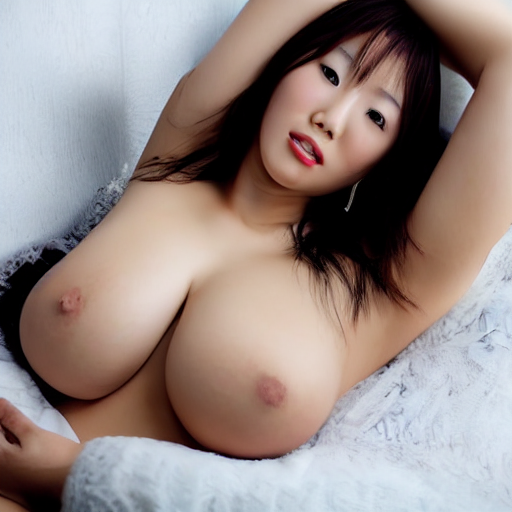

In [25]:
prompt = 'POV photograph featuring a beautiful busty 25-year-old Taiwanese woman with enormous tits and reclining naked on a bed and ha'
token_text_mapping = map_prompt_to_token(prompt)
print(token_text_mapping.to_string())
tokens = torch.tensor([token_text_mapping.loc[:,'token'].to_numpy()])
token_to_image(tokens)

/tmp/ipykernel_69618/2001643788.py:14: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),generator=generator,)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:13<00:00,  6.26s/it]


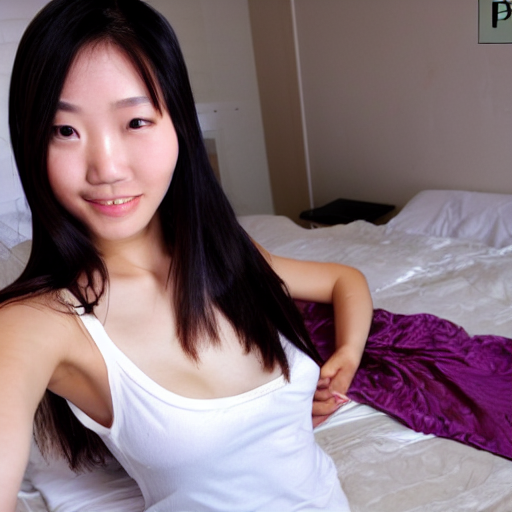

In [26]:
# Substitute bad tokens
def detoxify(indices):
    for index in indices:
        token_text_mapping.loc[index,'token'] = 49407
detoxify([6,7,16,17,18,19,21,22,23])
tokens = torch.tensor([token_text_mapping.loc[:,'token'].to_numpy()])
token_to_image(tokens)

## Interface

Now I need to develope an interface for it.

# Generate image

Reference from the other ipynb 

In [ ]:
df=pd.DataFrame()

for i in range(len(dataset['prompt'])):
    prompt = dataset['prompt'][i]
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
        print(text_input.input_ids)
        break
    
    # Get text embedding, save to csv
    # Todo: shape not correctly saved
    df = pd.concat([df, pd.DataFrame([text_embeddings.cpu().numpy()[0][0]])], ignore_index=True)

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),generator=generator,)
    latents = latents.to(torch_device)
    scheduler.set_timesteps(num_inference_steps)
    latents = latents * scheduler.init_noise_sigma
    
    # Diffusion phase, can be ignore for now.
    for t in tqdm(scheduler.timesteps):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)

        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
        image = vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    pil_images[0].save(os.path.join("./gen_img/stablediffusion1.4",f"{i}.jpg"))
df.to_csv('vec.csv',index=False)

In [ ]:
df.shape
